# Assignment-7-part-2
Transfer Learning on Various Modalities: Images, Video, Audio

## Description
Part 2 - Transfer learning on various modalities :
Write simple colabs to transfer learn on images, videos, audios - with both as a feature extractor as well as a fine tuning usecases.



In [9]:
!pip install tensorflow
!pip install tensorflow-hub
!pip install huggingface_hub
!pip install datasets
!pip install transformers
!pip install pydub
!pip install noisereduce

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2,  InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, GlobalAveragePooling3D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import os

import pandas as pd
import librosa
from IPython.display import Audio
from matplotlib import pyplot as plt
import librosa.display
import noisereduce as nr
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns


## Image Dataset

In [3]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar xfz flower_photos.tgz

--2024-05-03 23:56:38--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   247MB/s    in 0.9s    

2024-05-03 23:56:39 (247 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [24]:
# Load Oxford Flowers dataset
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    'flower_photos',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    'flower_photos',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


### Feature Extraction

In [5]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
# Freeze the base model for feature extraction
base_model.trainable = False

In [7]:
# Add a classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model with the base model frozen (feature extraction)
print("Training the model with feature extraction...")
history_extraction = model.fit(train_generator, epochs=10, validation_data=validation_generator)


Training the model with feature extraction...
Epoch 1/10
92/92 [==============================] - 19s 131ms/step - loss: 0.5083 - accuracy: 0.8139 - val_loss: 0.3980 - val_accuracy: 0.8495
Epoch 2/10
92/92 [==============================] - 10s 113ms/step - loss: 0.2166 - accuracy: 0.9228 - val_loss: 0.3591 - val_accuracy: 0.8796
Epoch 3/10
92/92 [==============================] - 10s 113ms/step - loss: 0.1276 - accuracy: 0.9605 - val_loss: 0.4181 - val_accuracy: 0.8577
Epoch 4/10
92/92 [==============================] - 11s 119ms/step - loss: 0.0599 - accuracy: 0.9850 - val_loss: 0.4401 - val_accuracy: 0.8646
Epoch 5/10
92/92 [==============================] - 10s 114ms/step - loss: 0.0283 - accuracy: 0.9956 - val_loss: 0.4438 - val_accuracy: 0.8700
Epoch 6/10
92/92 [==============================] - 11s 117ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.4729 - val_accuracy: 0.8700
Epoch 7/10
92/92 [==============================] - 12s 126ms/step - loss: 0.0071 - accuracy: 1.

### Fine-tuning

In [11]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

In [12]:
# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Fine-tune the model
print("Fine-tuning the model...")
history_finetuning = model.fit(train_generator, epochs=3, validation_data=validation_generator)

Fine-tuning the model...
Epoch 1/3
92/92 [==============================] - 50s 295ms/step - loss: 0.4795 - accuracy: 0.8435 - val_loss: 0.5234 - val_accuracy: 0.8755
Epoch 2/3
92/92 [==============================] - 15s 159ms/step - loss: 0.2436 - accuracy: 0.9149 - val_loss: 0.5189 - val_accuracy: 0.8782
Epoch 3/3
92/92 [==============================] - 15s 158ms/step - loss: 0.1793 - accuracy: 0.9350 - val_loss: 0.5027 - val_accuracy: 0.8810


###  Visualizations

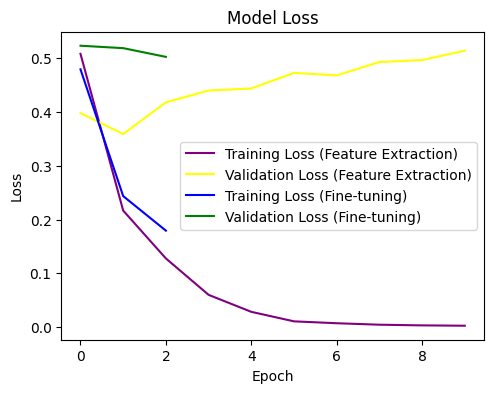

In [30]:
# Visualize the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_extraction.history['loss'], label='Training Loss (Feature Extraction)',color='purple')
plt.plot(history_extraction.history['val_loss'], label='Validation Loss (Feature Extraction)',color='yellow')
plt.plot(history_finetuning.history['loss'], label='Training Loss (Fine-tuning)',color='blue')
plt.plot(history_finetuning.history['val_loss'], label='Validation Loss (Fine-tuning)',color='green')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

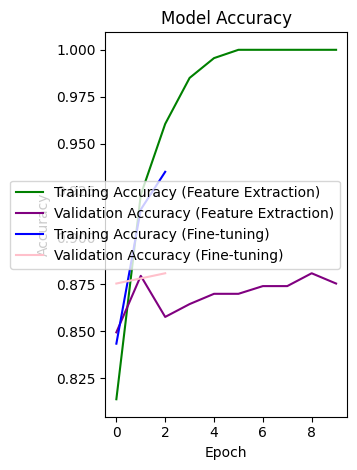

In [32]:
# Visualize the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_extraction.history['accuracy'], label='Training Accuracy (Feature Extraction)',color='green')
plt.plot(history_extraction.history['val_accuracy'], label='Validation Accuracy (Feature Extraction)',color='purple')
plt.plot(history_finetuning.history['accuracy'], label='Training Accuracy (Fine-tuning)',color='blue')
plt.plot(history_finetuning.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)',color='pink')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Video Dataset

In [3]:
!sudo apt install -y ffmpeg
!pip install -q mediapy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [4]:
# Import libraries
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL

import tensorflow as tf
import tensorflow_hub as hub
import tqdm

mpl.rcParams.update({
    'font.size': 10,
})

In [6]:
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging'], dtype='<U49')

In [7]:
jumpingjack_url = 'https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif'
jumpingjack_path = tf.keras.utils.get_file(
    fname='jumpingjack.gif',
    origin=jumpingjack_url,
    cache_dir='.', cache_subdir='.',
)

In [8]:
# Read and process a video
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
  # Load a gif file, convert it to a TF tensor
  raw = tf.io.read_file(file_path)
  video = tf.io.decode_gif(raw)
  # Resize the video
  video = tf.image.resize(video, image_size)
  # change dtype to a float32
  # Hub models always want images normalized to [0,1]
  # ref: https://www.tensorflow.org/hub/common_signatures/images#input
  video = tf.cast(video, tf.float32) / 255.
  return video

In [9]:
jumpingjack=load_gif(jumpingjack_path)
jumpingjack.shape

TensorShape([13, 224, 224, 3])

In [10]:
%%time
id = 'a2'
mode = 'base'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: user 20.8 s, sys: 928 ms, total: 21.7 s
Wall time: 27.1 s


Dataset

In [1]:
!kaggle datasets download -d alexeychinyaev/kth-video-dataset
!unzip kth-video-dataset.zip -d Dataset

Dataset URL: https://www.kaggle.com/datasets/alexeychinyaev/kth-video-dataset
License(s): unknown
100% 455M/456M [00:21<00:00, 25.6MB/s]
100% 456M/456M [00:21<00:00, 22.4MB/s]
Archive:  kth-video-dataset.zip
  inflating: Dataset/boxing/person01_boxing_d4_uncomp.avi  
  inflating: Dataset/handwaving/person01_handwaving_d2_uncomp.avi  
  inflating: Dataset/jogging/person01_jogging_d1_uncomp.avi  
  inflating: Dataset/jogging/person01_jogging_d2_uncomp.avi  
  inflating: Dataset/jogging/person01_jogging_d3_uncomp.avi  
  inflating: Dataset/jogging/person01_jogging_d4_uncomp.avi  
  inflating: Dataset/jogging/person02_jogging_d1_uncomp.avi  
  inflating: Dataset/jogging/person02_jogging_d2_uncomp.avi  
  inflating: Dataset/jogging/person02_jogging_d3_uncomp.avi  
  inflating: Dataset/jogging/person02_jogging_d4_uncomp.avi  
  inflating: Dataset/jogging/person03_jogging_d1_uncomp.avi  
  inflating: Dataset/jogging/person03_jogging_d2_uncomp.avi  
  inflating: Dataset/jogging/person03_joggin

In [2]:
import os

# Rest of the code remains the same

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 15
DATASET_PATH = "/content/Dataset"

CLASS_LABELS = ["boxing", "running", "walking"]

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

def create_dataset():
    # Declared Empty Lists to store the featuress, labels and video file path values.
    featuress = []
    labelss = []
    video_files_pathss = []
    for class_index, class_name in enumerate(CLASS_LABELS):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_PATH, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_PATH, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                featuress.append(frames)
                labelss.append(class_index)
                video_files_pathss.append(video_file_path)

    featuress = np.asarray(featuress)
    labelss = np.array(labelss)
    return featuress, labelss, video_files_pathss

In [6]:
static_features, static_labels, static_video_files_paths = create_dataset()

Extracting Data of Class: boxing
Extracting Data of Class: running
Extracting Data of Class: walking


 Feature Extraction

In [7]:
features, labels, video_files_paths = static_features, static_labels, static_video_files_paths

In [11]:
videos = np.array(features)
labels = np.array(labels)
videos = videos.astype('float32') / 255
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels, num_classes=len(CLASS_LABELS))

In [12]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

In [13]:
print(f"x_train.shape = {x_train.shape}")
print(f"x_test.shape = {x_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

x_train.shape = (158, 15, 64, 64, 3)
x_test.shape = (40, 15, 64, 64, 3)
y_train.shape = (158, 3)
y_test.shape = (40, 3)


### Fine-tuning Model

In [14]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Fine-tuning model
model = Sequential()
model.add(TimeDistributed(base_model, input_shape=(15, 64, 64, 3)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(256))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



9406464/9406464 [==============================] - 1s 0us/step


In [16]:
# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
5/5 [==============================] - 59s 12s/step - loss: 0.7301 - accuracy: 0.5380 - val_loss: 0.7723 - val_accuracy: 0.4750
Epoch 2/2
5/5 [==============================] - 66s 14s/step - loss: 0.5388 - accuracy: 0.7595 - val_loss: 0.9311 - val_accuracy: 0.4750


###  Visualizations

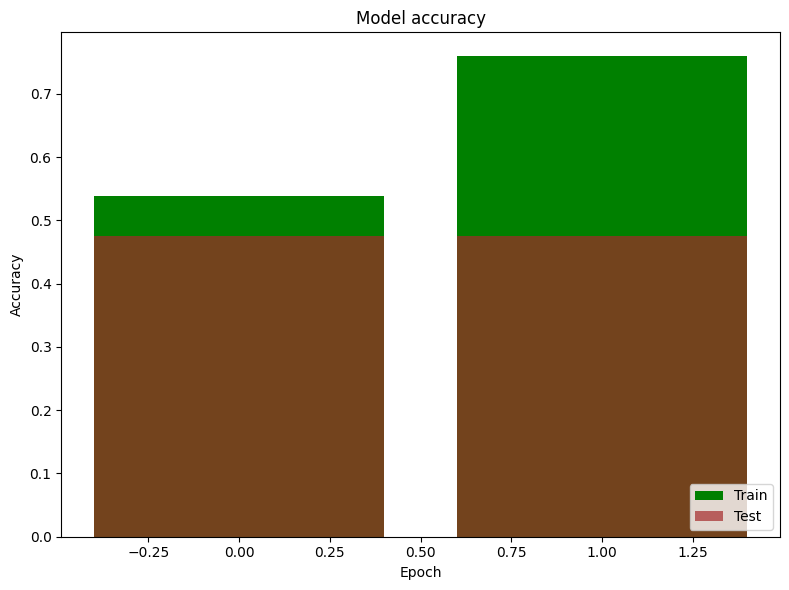

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))

# Bar plot for training accuracy
plt.bar(np.arange(len(history.history['accuracy'])), history.history['accuracy'], color='green', label='Train')
# Bar plot for validation accuracy
plt.bar(np.arange(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='brown', alpha=0.7, label='Test')

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


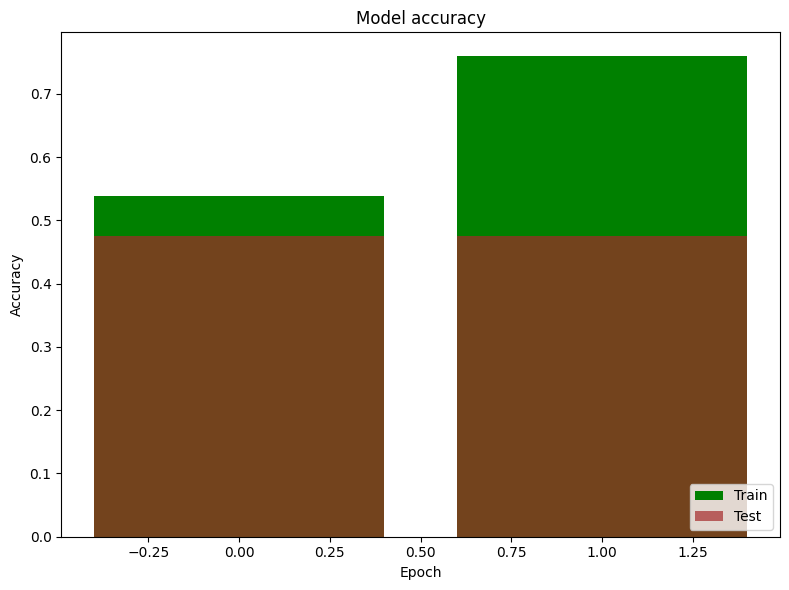

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))

# Bar plot for training accuracy
plt.bar(np.arange(len(history.history['accuracy'])), history.history['accuracy'], color='green', label='Train')
# Bar plot for validation accuracy
plt.bar(np.arange(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='brown', alpha=0.7, label='Test')

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


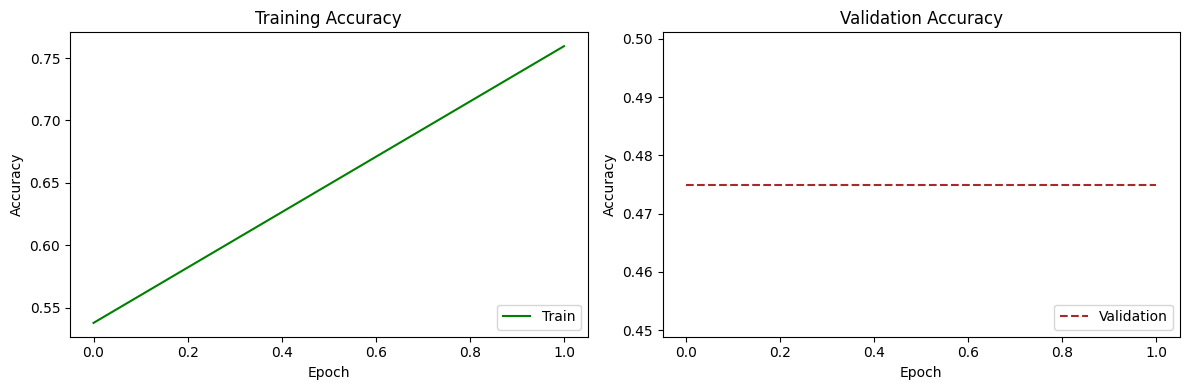

In [23]:
# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training accuracy
ax1.plot(history.history['accuracy'], label='Train', color='green')
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# Plot validation accuracy
ax2.plot(history.history['val_accuracy'], label='Validation', color='brown', linestyle="--")
ax2.set_title('Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(loc='lower right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Audio Dataset

In [24]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en
!unzip speech-emotion-recognition-en.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

In [25]:
data = []
label = []
meta = []
sampling_rate = 18000

In [27]:
def play_plot(index):
    print(meta[index])
    Audio(data=data[index], rate=sampling_rate)
    #fig, ax = plt.subplots(nrows=3, sharex=True)
    #librosa.display.waveshow(data[index], sr=sampling_rate, ax=ax[0])

def adjust_length(time_series_list, length):
    n = len(time_series_list)
    for i in range(n):
        audio_length = len(time_series_list[i])
        if audio_length < length:
            time_series_list[i] = np.append(time_series_list[i], [0 for i in range(length-audio_length)])
        else:
            time_series_list[i] = np.array(time_series_list[i][:length])

def check_for_nan(l):
    for x in l:
        if str(x) == 'nan':
            return True
    return False

In [28]:
emotions_dict = dict()
emotions_dict['SAD'] = 0
emotions_dict['ANG'] = 1
emotions_dict['DIS'] = 2
emotions_dict['FEA'] = 3
emotions_dict['HAP'] = 4
emotions_dict['NEU'] = 5

In [29]:
length_sum = 0
list_a = []
list_b = []
for dirname, _, filenames in os.walk('Crema'):
    for filename in filenames:
        meta.append(filename[:-4])
        full_filename = os.path.join(dirname, filename)
        sentiment = filename.split('_')[2]
        label.append(emotions_dict[sentiment])
        signal, sr = librosa.load(full_filename, sr = sampling_rate)
        reduced_noise = nr.reduce_noise(y=signal, sr=sampling_rate)
        if not check_for_nan(reduced_noise):
            signal = reduced_noise
        data.append(signal)
        length_sum += len(signal)
        if (len(data)%100 == 0):
            print(len(data), " audio loaded")
n = len(data)
adjust_length(data, 3*sampling_rate)
data = np.array(data)

100  audio loaded
200  audio loaded
300  audio loaded
400  audio loaded
500  audio loaded
600  audio loaded
700  audio loaded
800  audio loaded
900  audio loaded
1000  audio loaded
1100  audio loaded
1200  audio loaded
1300  audio loaded
1400  audio loaded
1500  audio loaded
1600  audio loaded
1700  audio loaded
1800  audio loaded
1900  audio loaded
2000  audio loaded
2100  audio loaded
2200  audio loaded
2300  audio loaded
2400  audio loaded
2500  audio loaded
2600  audio loaded
2700  audio loaded
2800  audio loaded
2900  audio loaded
3000  audio loaded
3100  audio loaded
3200  audio loaded
3300  audio loaded
3400  audio loaded
3500  audio loaded
3600  audio loaded
3700  audio loaded
3800  audio loaded
3900  audio loaded
4000  audio loaded
4100  audio loaded
4200  audio loaded
4300  audio loaded
4400  audio loaded
4500  audio loaded
4600  audio loaded
4700  audio loaded
4800  audio loaded
4900  audio loaded
5000  audio loaded
5100  audio loaded
5200  audio loaded
5300  audio loaded
54

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


6900  audio loaded
7000  audio loaded
7100  audio loaded
7200  audio loaded
7300  audio loaded
7400  audio loaded


 Display Metadata, Play Audio, and Plot Waveform

index = 5

Audio(data=data[index], rate=sampling_rate)

fig = plt.figure(figsize=(15,5))
fig.suptitle(meta[index], fontsize=15)
librosa.display.waveshow(data[index], sr=sampling_rate)

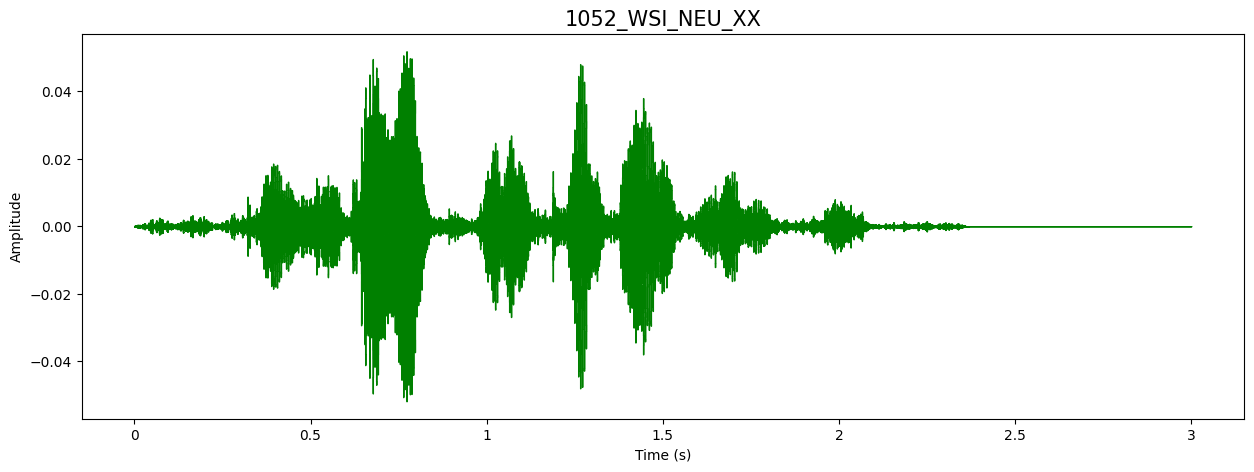

In [34]:
index=5
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(15, 5))
plt.title(meta[index], fontsize=15)
librosa.display.waveshow(data[index], sr=sampling_rate, color="green")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


### Feature Extraction

In [36]:
def feature_extraction_1D(data):
    features = librosa.feature.zero_crossing_rate(y=data)
    features = np.append(features, librosa.feature.rms(y=data), axis=1)
    l = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0).reshape(1, 106)
    features = np.append(features, l, axis=1)
    features = np.append(features, librosa.feature.spectral_centroid(y=data, sr=sampling_rate), axis=1)
    features = np.append(features, librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate), axis=1)
    features = np.append(features, librosa.feature.spectral_flatness(y=data), axis=1)
    features = np.append(features, librosa.feature.spectral_rolloff(y=data, sr=sampling_rate), axis=1)
    features = np.append(features, librosa.feature.spectral_rolloff(y=data, sr=sampling_rate, roll_percent=0.01), axis=1)

    return np.array(features)

In [37]:
data_features_extracted_1D = []
for i in range(n):
    data_features_extracted_1D.append(np.squeeze(np.append(feature_extraction_1D(data[i]), label[i])))
    if (len(data_features_extracted_1D)%100 == 0):
            print(len(data_features_extracted_1D), " entry processed")
data_features_extracted_1D = np.array(data_features_extracted_1D)
print(data_features_extracted_1D.shape)

100  entry processed
200  entry processed
300  entry processed
400  entry processed
500  entry processed
600  entry processed
700  entry processed
800  entry processed
900  entry processed
1000  entry processed
1100  entry processed
1200  entry processed
1300  entry processed
1400  entry processed
1500  entry processed
1600  entry processed
1700  entry processed
1800  entry processed
1900  entry processed
2000  entry processed
2100  entry processed
2200  entry processed
2300  entry processed
2400  entry processed
2500  entry processed
2600  entry processed
2700  entry processed
2800  entry processed
2900  entry processed
3000  entry processed
3100  entry processed
3200  entry processed
3300  entry processed
3400  entry processed
3500  entry processed
3600  entry processed
3700  entry processed
3800  entry processed
3900  entry processed
4000  entry processed
4100  entry processed
4200  entry processed
4300  entry processed
4400  entry processed
4500  entry processed
4600  entry process

In [38]:
def split_1D(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y)
    return x_train, x_test, y_train, y_test

In [39]:
x_train, x_test, y_train, y_test = split_1D(data_features_extracted_1D[:, :-1], label)

In [40]:
class AudioDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]

In [41]:
train_ds = AudioDataset(x_train, y_train)
test_ds = AudioDataset(x_test, y_test)
train_dl = DataLoader(train_ds, batch_size = 1000,shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 100,shuffle = False)

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 =self.audio()
        self.layer2=self.linear()

    def audio(self):
        layer=nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=3),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,padding=1),nn.ReLU(),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=128,out_channels=256,kernel_size=3,padding=1),nn.ReLU(),
            nn.Conv1d(in_channels=256,out_channels=256,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=256,out_channels=512,kernel_size=3,padding=1),nn.ReLU(),
            nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2)
        )
        return layer
    def linear(self):
        layer=nn.Sequential(
                nn.Flatten(),
                nn.Linear(4096,1024),nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024,6)
                )
        return layer

    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

In [53]:
def train_one_epoch(model, optimizer, train_dl):
    device = "cpu"
    train_loss = 0
    for X, y in train_dl:
        model.train()
        X = X.unsqueeze(1).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = F.cross_entropy(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
    train_loss = train_loss / len(train_dl.dataset)
    return train_loss


In [54]:
def test(model, test_dl):
    device = "cpu"
    test_loss = 0
    accuracy = 0
    for X, y in test_dl:
        X = X.unsqueeze(1).to(device)
        y = y.to(device)
        model.eval()
        y_pred = model(X)
        loss = F.cross_entropy(y_pred, y)

        test_loss += loss.item() * X.size(0)
        accuracy += sum(y_pred.argmax(dim=1) == y)
        torch.cuda.empty_cache()
    # calculate accuracy and loss
    test_loss = test_loss / len(test_dl.dataset)
    accuracy = accuracy / len(test_dl.dataset)
    return test_loss, accuracy.item()


In [45]:
def train_loop(model, optimizer, train_dl, test_dl, epochs):
    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = train_one_epoch(model, optimizer, train_dl)
        test_loss, test_acc = test(model, test_dl)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append(test_acc)

        if epoch % 5 == 0:
            print(
                f"Epoch {epoch}: Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}"
            )
    return train_losses, test_losses, accuracies

In [63]:
import matplotlib.pyplot as plt

def create_plots(train_losses, test_losses, accuracies):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plotting the training loss
    axs[0].plot(train_losses, label='Training Loss', color='blue')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting the validation loss
    axs[1].plot(test_losses, label='Validation Loss', color='red')
    axs[1].set_title('Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


### Fine-tuning

In [59]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)
train_losses_1, test_losses_1, accuracies_1 = train_loop(model, optimizer, train_dl, test_dl, 3)


Epoch 0: Train Loss: 1.969, Test Loss: 1.788, Test Accuracy: 0.171


###  Visualizations

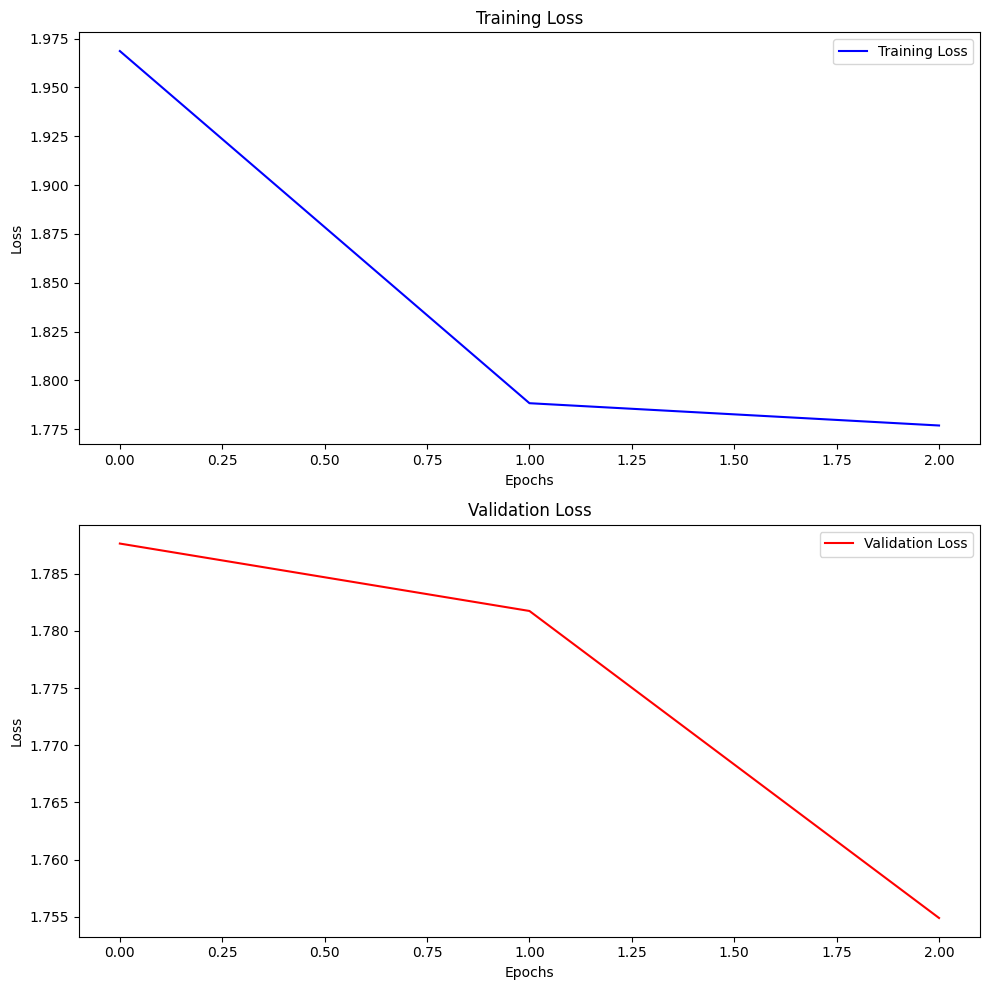

In [64]:
create_plots(train_losses_1, test_losses_1, accuracies_1)